In [17]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from pycocotools.coco import COCO
import cv2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.patches import Patch

#!pip install webcolors
import webcolors

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())
%matplotlib inline
# GPU 사용 가능 여부에 따라 device 정보 저장
device = "cuda" if torch.cuda.is_available() else "cpu"

class_colormap = pd.read_csv("/opt/ml/input/code/class_dict.csv")

pytorch version: 1.13.1+cu117
GPU 사용 가능 여부: True
Tesla V100-PCIE-32GB
1


## seed 고정 및 데이터 경로 설정

In [18]:
# seed 고정
random_seed = 21
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [89]:
dataset_path  = '/opt/ml/input/data'
anns_file_path = dataset_path + '/' + 'train_all.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())
    
coco = COCO(anns_file_path)

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

cat_names = []
for cat_it in categories:
    cat_names.append(cat_it['name'])

print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']-1] += 1

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)


loading annotations into memory...
Done (t=4.41s)
creating index...
index created!
Number of categories: 10
Number of annotations: 26240
Number of images: 3272


In [90]:
# 관련 함수
# category labeling 
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)
category_names = list(sorted_df.Categories)

def create_trash_label_colormap():
    """Creates a label colormap used in Trash segmentation.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (_, r, g, b) in enumerate(class_colormap.values):
        colormap[inex] = [r, g, b]
    
    return colormap

def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
                is the color indexed by the corresponding element in the input label
                to the trash color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
              map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"


def getItem(index):
    image_id = coco.getImgIds(imgIds=index)
    image_infos = coco.loadImgs(image_id)[0]
    
    # cv2 를 활용하여 image 불러오기
    images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
    images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
    images /= 255.0
    
    ann_ids = coco.getAnnIds(imgIds=image_infos['id'])
    anns = coco.loadAnns(ann_ids)
    # Load the categories in a variable
    cat_ids = coco.getCatIds()
    cats = coco.loadCats(cat_ids)

    # masks : size가 (height x width)인 2D
    # 각각의 pixel 값에는 "category id" 할당
    # Background = 0
    masks = np.zeros((image_infos["height"], image_infos["width"]))
    # General trash = 1, ... , Cigarette = 10
    anns = sorted(anns, key=lambda idx : idx['area'], reverse=True)
    for i in range(len(anns)):
        className = get_classname(anns[i]['category_id'], cats)
        pixel_value = category_names.index(className)
        masks[coco.annToMask(anns[i]) == 1] = pixel_value
    masks = masks.astype(np.int8)
    return images, masks, image_infos

In [91]:
# label 평균 중앙 좌표
Paper_avg_x = []
Plastic_bag_avg_x = []
Plastic_avg_x = []
General_avg_x = []
Styrofoam_avg_x = []
Paper_pack_avg_x = []
Glass_avg_x = []
Metal_avg_x = []
Clothing_avg_x = []
Battery_avg_x = []

Paper_avg_y = []
Plastic_bag_avg_y = []
Plastic_avg_y = []
General_avg_y = []
Styrofoam_avg_y = []
Paper_pack_avg_y = []
Glass_avg_y = []
Metal_avg_y = []
Clothing_avg_y = []
Battery_avg_y = []

Paper_area = []
Plastic_bag_area = []
Plastic_area = []
General_area = []
Styrofoam_area = []
Paper_pack_area = []
Glass_area = []
Metal_area = []
Clothing_area = []
Battery_area = []

for index in range(len(coco.getImgIds())):
    image_id = coco.getImgIds(imgIds=index)
    image_infos = coco.loadImgs(image_id)[0]
    ann_ids = coco.getAnnIds(imgIds=image_infos['id'])
    anns = coco.loadAnns(ann_ids)

    anns = sorted(anns, key=lambda idx : idx['area'], reverse=True)
    # Load the categories in a variable
    cat_ids = coco.getCatIds()
    cats = coco.loadCats(cat_ids)
    
    for i in range(len(anns)):
        className = get_classname(anns[i]['category_id'], cats)
        temp_ann_x = anns[i]['bbox'][0] + (anns[i]['bbox'][2] / 2)
        temp_ann_y = anns[i]['bbox'][1] + (anns[i]['bbox'][3] / 2)
        temp_ann_area = anns[i]['area']
        if className == 'Paper':
            Paper_avg_x.append(temp_ann_x)
            Paper_avg_y.append(temp_ann_y)
            Paper_area.append(temp_ann_area)
        elif className == 'Plastic bag':
            Plastic_bag_avg_x.append(temp_ann_x)
            Plastic_bag_avg_y.append(temp_ann_y)
            Plastic_bag_area.append(temp_ann_area)
        elif className == 'Plastic':
            Plastic_avg_x.append(temp_ann_x)
            Plastic_avg_y.append(temp_ann_y)
            Plastic_area.append(temp_ann_area) 
        elif className == 'General trash':
            General_avg_x.append(temp_ann_x)
            General_avg_y.append(temp_ann_y)
            General_area.append(temp_ann_area) 
        elif className == 'Styrofoam':
            Styrofoam_avg_x.append(temp_ann_x)
            Styrofoam_avg_y.append(temp_ann_y)
            Styrofoam_area.append(temp_ann_area) 
        elif className == 'Paper pack':
            Paper_pack_avg_x.append(temp_ann_x)
            Paper_pack_avg_y.append(temp_ann_y)
            Paper_pack_area.append(temp_ann_area) 
        elif className == 'Glass':
            Glass_avg_x.append(temp_ann_x)
            Glass_avg_y.append(temp_ann_y)
            Glass_area.append(temp_ann_area) 
        elif className == 'Metal':
            Metal_avg_x.append(temp_ann_x)
            Metal_avg_y.append(temp_ann_y)
            Metal_area.append(temp_ann_area) 
        elif className == 'Clothing':
            Clothing_avg_x.append(temp_ann_x)
            Clothing_avg_y.append(temp_ann_y)
            Clothing_area.append(temp_ann_area) 
        elif className == 'Battery':
            Battery_avg_x.append(temp_ann_x)
            Battery_avg_y.append(temp_ann_y)
            Battery_area.append(temp_ann_area)
        else:
            print("error", className)
df_Paper = pd.DataFrame({'avg_x': Paper_avg_x, 'avg_y': Paper_avg_y, 'area': Paper_area})
df_Plastic_bag = pd.DataFrame({'avg_x': Plastic_bag_avg_x, 'avg_y': Plastic_bag_avg_y, 'area': Plastic_bag_area})
df_Plastic = pd.DataFrame({'avg_x': Plastic_avg_x, 'avg_y': Plastic_avg_y, 'area': Plastic_area})
df_General = pd.DataFrame({'avg_x': General_avg_x, 'avg_y': General_avg_y, 'area': General_area})
df_Styrofoam = pd.DataFrame({'avg_x': Styrofoam_avg_x, 'avg_y': Styrofoam_avg_y, 'area': Styrofoam_area})
df_Paper_pack = pd.DataFrame({'avg_x': Paper_pack_avg_x, 'avg_y': Paper_pack_avg_y, 'area': Paper_pack_area})
df_Glass = pd.DataFrame({'avg_x': Glass_avg_x, 'avg_y': Glass_avg_y, 'area': Glass_area})
df_Metal = pd.DataFrame({'avg_x': Metal_avg_x, 'avg_y': Metal_avg_y, 'area': Metal_area})
df_Clothing = pd.DataFrame({'avg_x': Clothing_avg_x, 'avg_y': Clothing_avg_y, 'area': Clothing_area})
df_Battery = pd.DataFrame({'avg_x': Battery_avg_x, 'avg_y': Battery_avg_y, 'area': Battery_area})

# 데이터 EDA

### 총 이미지 annotation 수

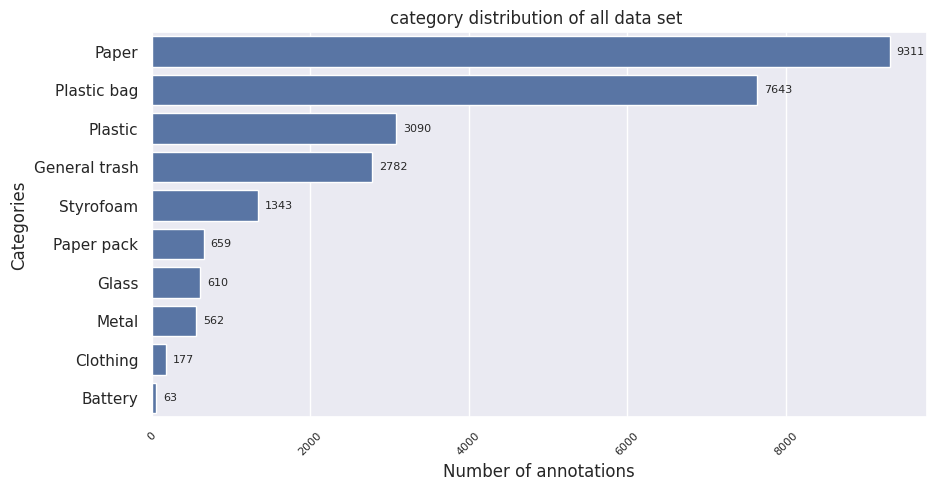

In [92]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10,5))
# Plot the histogram
plt.title("category distribution of all data set ")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df, label="Total", color="b")
for p in plot_1.patches: 
    plot_1.annotate("%.0f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center", size = 8)   

plt.xticks(fontsize=8, rotation=45)
plt.show()

### Class별 평균 x,y 위치

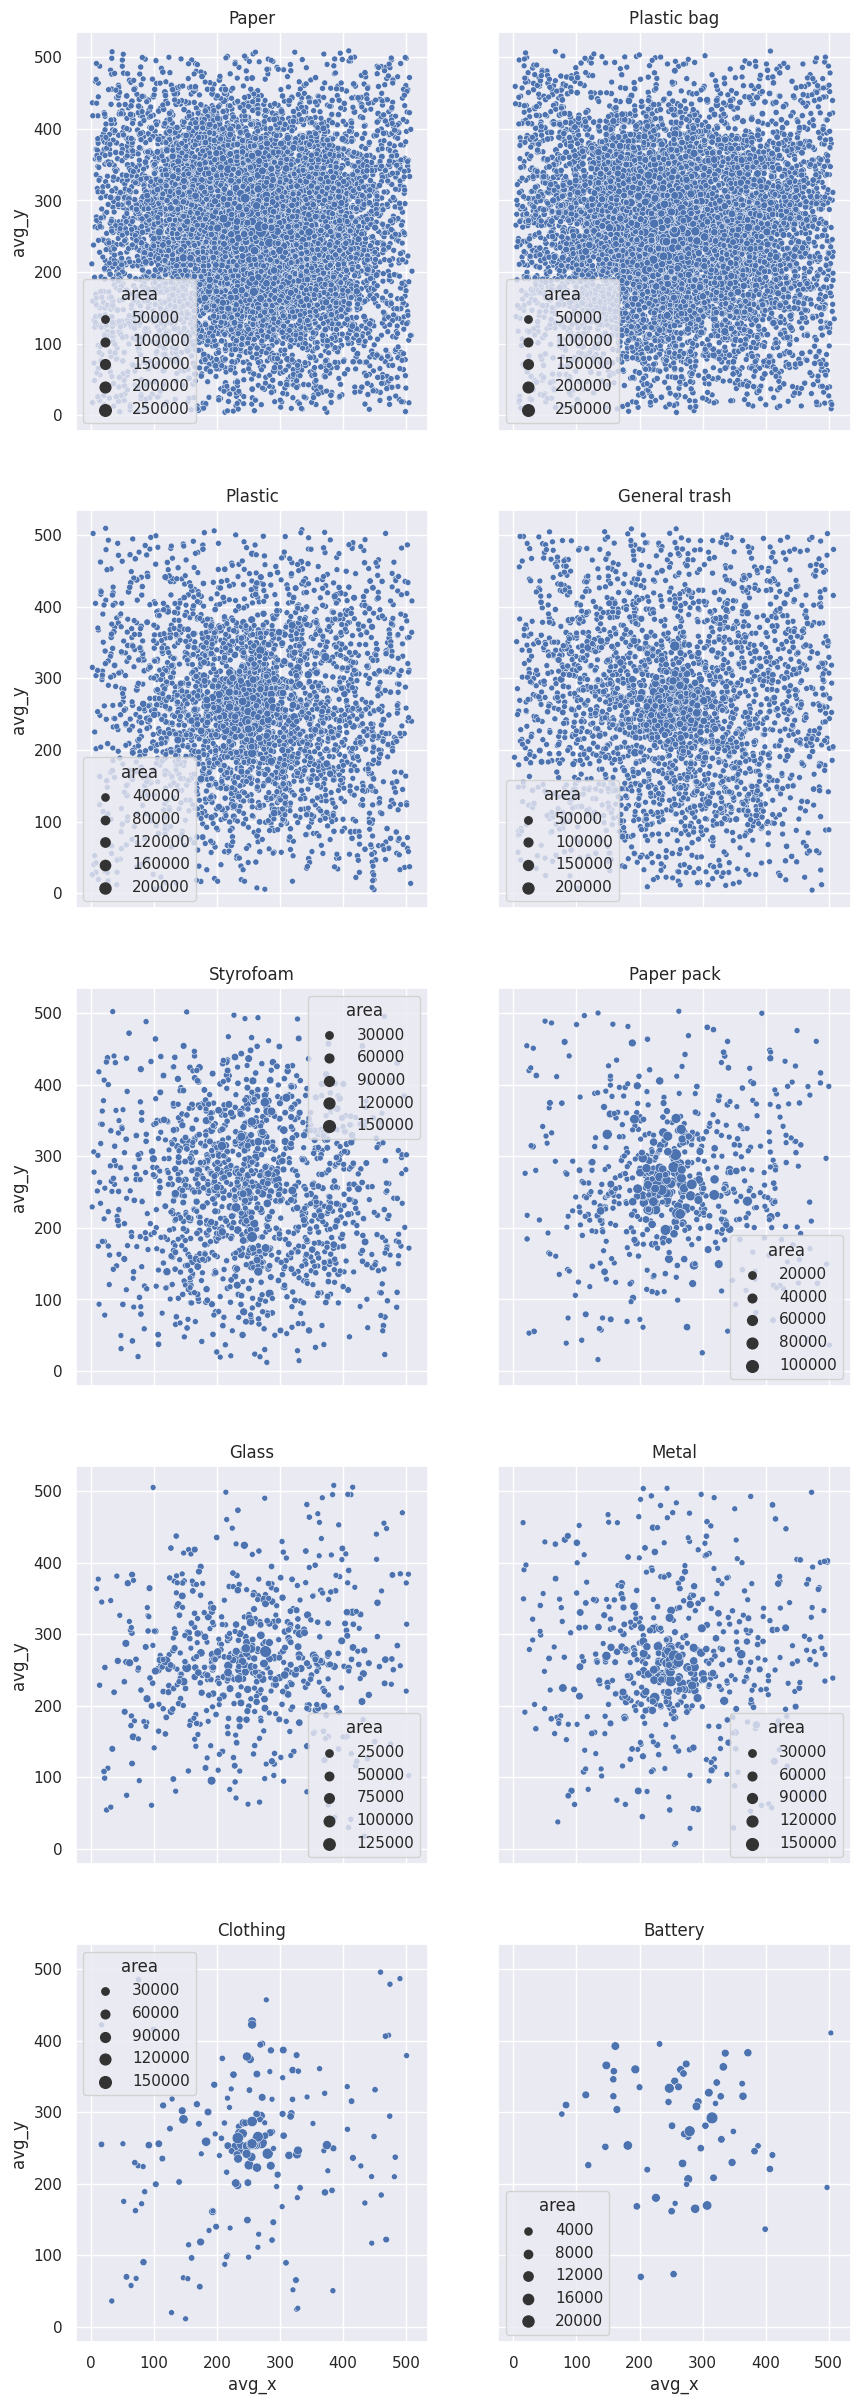

In [65]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 30),sharey=True,sharex=True)
axes[0][0].set_title("Paper")
axes[0][0] = sns.scatterplot(data=df_Paper, x='avg_x', y='avg_y', size='area', ax=axes[0][0])
axes[0][1].set_title("Plastic bag")
axes[0][1] = sns.scatterplot(data=df_Plastic_bag, x='avg_x', y='avg_y', size='area', ax=axes[0][1])
axes[1][0].set_title("Plastic")
axes[1][0] = sns.scatterplot(data=df_Plastic, x='avg_x', y='avg_y', size='area', ax=axes[1][0])
axes[1][1].set_title("General trash")
axes[1][1] = sns.scatterplot(data=df_General, x='avg_x', y='avg_y', size='area', ax=axes[1][1])
axes[2][0].set_title("Styrofoam")
axes[2][0] = sns.scatterplot(data=df_Styrofoam, x='avg_x', y='avg_y', size='area', ax=axes[2][0])
axes[2][1].set_title("Paper pack")
axes[2][1] = sns.scatterplot(data=df_Paper_pack, x='avg_x', y='avg_y', size='area', ax=axes[2][1])
axes[3][0].set_title("Glass")
axes[3][0] = sns.scatterplot(data=df_Glass, x='avg_x', y='avg_y', size='area', ax=axes[3][0])
axes[3][1].set_title("Metal")
axes[3][1] = sns.scatterplot(data=df_Metal, x='avg_x', y='avg_y', size='area', ax=axes[3][1])
axes[4][0].set_title("Clothing")
axes[4][0] = sns.scatterplot(data=df_Clothing, x='avg_x', y='avg_y', size='area', ax=axes[4][0])
axes[4][1].set_title("Battery")
axes[4][1] = sns.scatterplot(data=df_Battery, x='avg_x', y='avg_y', size='area', ax=axes[4][1])
plt.show()

### 카테고리 별 annotation 크기

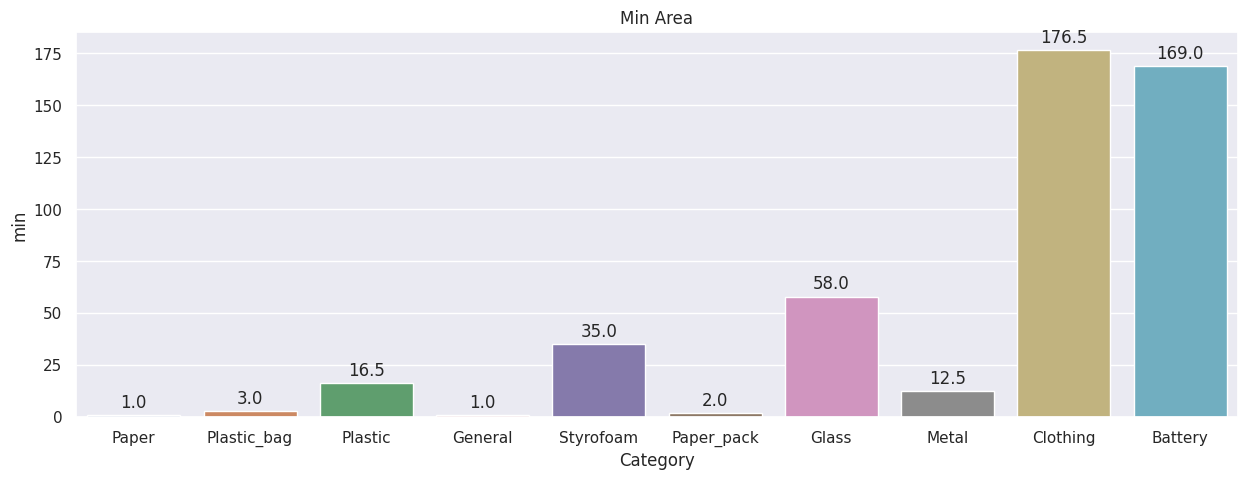

In [82]:
plt.figure(figsize=(15, 5))
plt.title("Min Area")

x = np.arange(10)
x_t = ['Paper','Plastic_bag','Plastic','General','Styrofoam','Paper_pack','Glass','Metal','Clothing','Battery']

Paper = df_Paper['area'].describe()['min']
Plastic_bag = df_Plastic_bag['area'].describe()['min']
Plastic = df_Plastic['area'].describe()['min']
General = df_General['area'].describe()['min']
Styrofoam = df_Styrofoam['area'].describe()['min']
Paper_pack = df_Paper_pack['area'].describe()['min']
Glass = df_Glass['area'].describe()['min']
Metal = df_Metal['area'].describe()['min']
Clothing = df_Clothing['area'].describe()['min']
Battery = df_Battery['area'].describe()['min']

min_df = pd.DataFrame({"Category":x_t, "min":[Paper,Plastic_bag,Plastic,General,Styrofoam,Paper_pack,Glass,Metal,Clothing,Battery]})
splot=sns.barplot(x="Category",y="min",data=min_df)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.show()

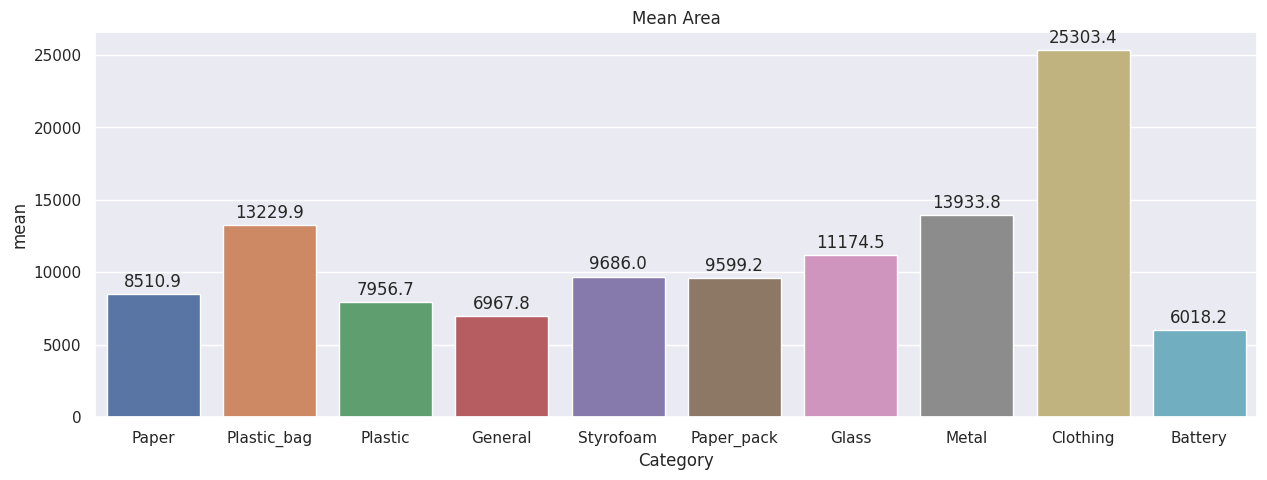

In [83]:
plt.figure(figsize=(15, 5))
plt.title("Mean Area")

x = np.arange(10)
x_t = ['Paper','Plastic_bag','Plastic','General','Styrofoam','Paper_pack','Glass','Metal','Clothing','Battery']

Paper = df_Paper['area'].describe()['mean']
Plastic_bag = df_Plastic_bag['area'].describe()['mean']
Plastic = df_Plastic['area'].describe()['mean']
General = df_General['area'].describe()['mean']
Styrofoam = df_Styrofoam['area'].describe()['mean']
Paper_pack = df_Paper_pack['area'].describe()['mean']
Glass = df_Glass['area'].describe()['mean']
Metal = df_Metal['area'].describe()['mean']
Clothing = df_Clothing['area'].describe()['mean']
Battery = df_Battery['area'].describe()['mean']

min_df = pd.DataFrame({"Category":x_t, "mean":[Paper,Plastic_bag,Plastic,General,Styrofoam,Paper_pack,Glass,Metal,Clothing,Battery]})
splot=sns.barplot(x="Category",y="mean",data=min_df)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.show()

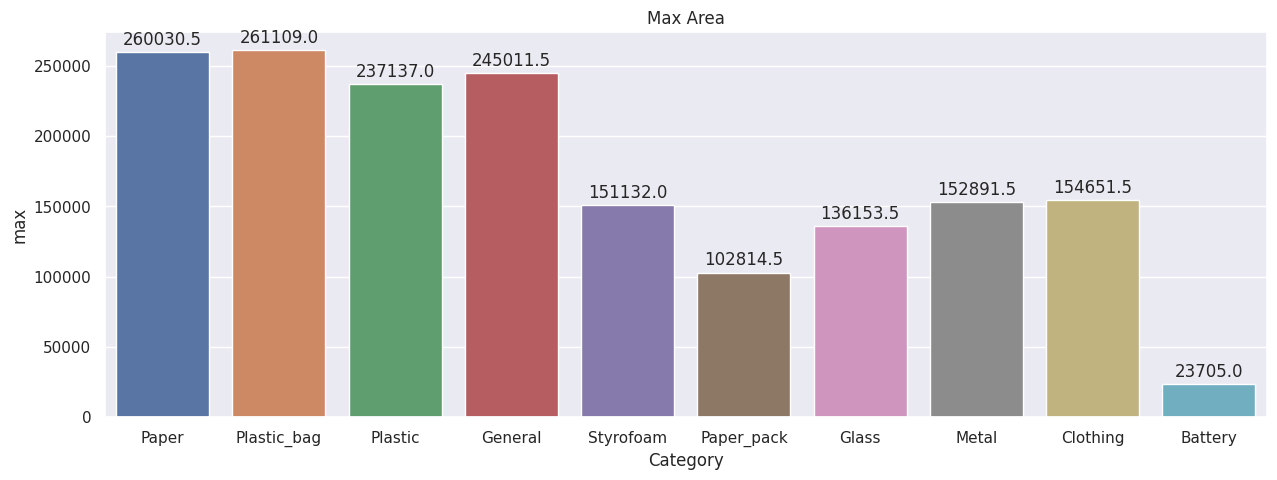

In [84]:
plt.figure(figsize=(15, 5))
plt.title("Max Area")

x = np.arange(10)
x_t = ['Paper','Plastic_bag','Plastic','General','Styrofoam','Paper_pack','Glass','Metal','Clothing','Battery']

Paper = df_Paper['area'].describe()['max']
Plastic_bag = df_Plastic_bag['area'].describe()['max']
Plastic = df_Plastic['area'].describe()['max']
General = df_General['area'].describe()['max']
Styrofoam = df_Styrofoam['area'].describe()['max']
Paper_pack = df_Paper_pack['area'].describe()['max']
Glass = df_Glass['area'].describe()['max']
Metal = df_Metal['area'].describe()['max']
Clothing = df_Clothing['area'].describe()['max']
Battery = df_Battery['area'].describe()['max']

min_df = pd.DataFrame({"Category":x_t, "max":[Paper,Plastic_bag,Plastic,General,Styrofoam,Paper_pack,Glass,Metal,Clothing,Battery]})
splot=sns.barplot(x="Category",y="max",data=min_df)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.show()

### EDA
- 데이터 불균형
  - paper, plastic bag, plastic, General trash에 비해 Styrofoam, Paper pack, Glass, Metal, Clothing, Battery의 annotation 수가 적음
  - Clothing, battery의 경우 크기가 안정되어있지만 Styrofoam, Paper pack, Glass, Metal의 경우 크기마저 불안정한 모습을 보임
- annotation 평균 좌표
  - object는 대부분 중앙에 크게 존재하고 가장자리로 갈수록 크기가 작아짐
- Noise 추정
  - 픽셀 단위의 아주작은 object가 다수 존재
  - 사진의 크기와 유사한 매우 큰 object 존재

## 데이터 시각화

image shape: [512, 512, 3]
mask shape:  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {2, 'Paper'}]


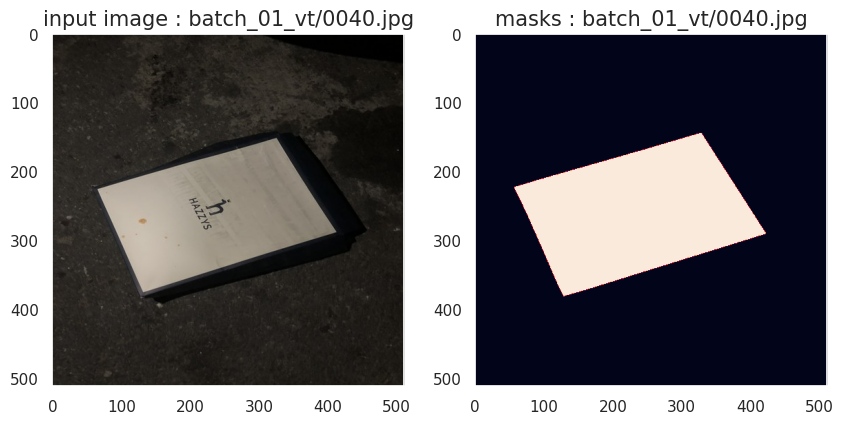

In [79]:
index = 30 # 0 ~ 3272
temp_image, temp_mask, temp_image_infos = getItem(index)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

print('image shape:', list(temp_image.shape))
print('mask shape: ', list(temp_mask.shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_mask))])

ax1.imshow(temp_image)#.permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(temp_image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_mask)
ax2.grid(False)
ax2.set_title("masks : {}".format(temp_image_infos['file_name']), fontsize = 15)

plt.show()

### 대표 논점
- 일반 쓰레기의 기준?
  - 1
- 라벨링 기준 애매
  - 11 vs 2
- Point rend 필요성?
  - 3
- 데이터 셋 라벨링의 일관성?
  - 26, 29, 40, 50, 84
- 데이터셋 오류가 생각보다 심하다
  - 데이터 라벨링이 되어있지 않은 경우도 있음
     - 113
- 투명한 이미지
  - 병, 비닐봉투, 페트병 에 대한 오류가 심할 것 같음
- small object
  - 107
- 기준이 너무 모호하다
  - 일반 쓰레기의 기준 (112)
  - 얼마나 세부적으로 할 것인지 (59)
  - 테이프는? (63)
- Plastic vs Plastic bag
- Paper vs paper pack

1. 데이터 클린징은 의미가 없을 것 같다.
2. 

### 이미지 연속 보기

In [80]:
from IPython.display import clear_output 

117
image shape: [512, 512, 3]
mask shape:  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {3, 'Paper pack'}, {5, 'Glass'}, {'Plastic', 6}]


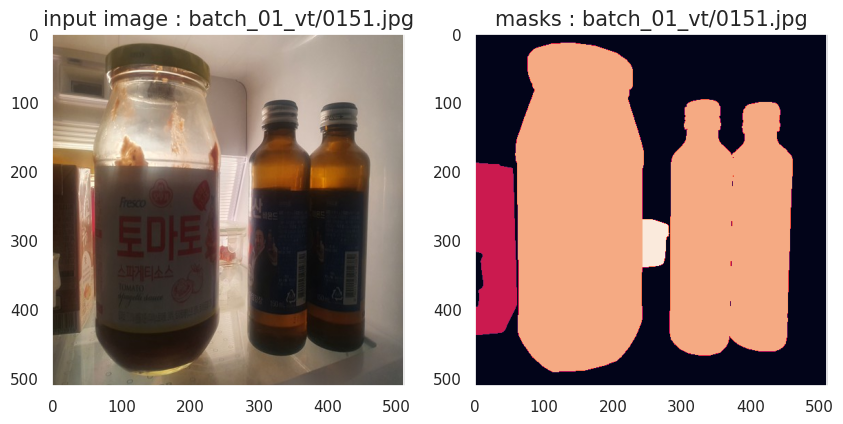

KeyboardInterrupt: Interrupted by user

In [83]:
start_index = 0 # 0 ~ 3272

for index in range(start_index, len(coco.getImgIds())):
    clear_output(wait=True)
    temp_image, temp_mask, temp_image_infos = getItem(index)

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

    print(index)
    print('image shape:', list(temp_image.shape))
    print('mask shape: ', list(temp_mask.shape))
    print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_mask))])

    ax1.imshow(temp_image)#.permute([1,2,0]))
    ax1.grid(False)
    ax1.set_title("input image : {}".format(temp_image_infos['file_name']), fontsize = 15)

    ax2.imshow(temp_mask)
    ax2.grid(False)
    ax2.set_title("masks : {}".format(temp_image_infos['file_name']), fontsize = 15)

    plt.show()
    
    temp = input('Press Any Key')